### GTSRB Traffic Sign Recognition - Part II

### CODE ONLY, For a detailed report, please refer to the GTSRB Final Report Part II

#### by Sean Sungil Kim

In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
# importing necessary modules
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
import time
import warnings
warnings.filterwarnings("ignore")

# custom python scripts
import GTSRB_sungil           # preprocessing
import Models_sungil          # exploratory analysis and model fitting/comparisons

### Preprocessing

In [3]:
# reading the GTSRB data utilizing the custom python script
# grayscaled
num_classes = 43
data_GTSRB, data_class, labels = GTSRB_sungil.load_data(num_classes)
gray_GTSRB = GTSRB_sungil.gray_convrt(data_GTSRB)

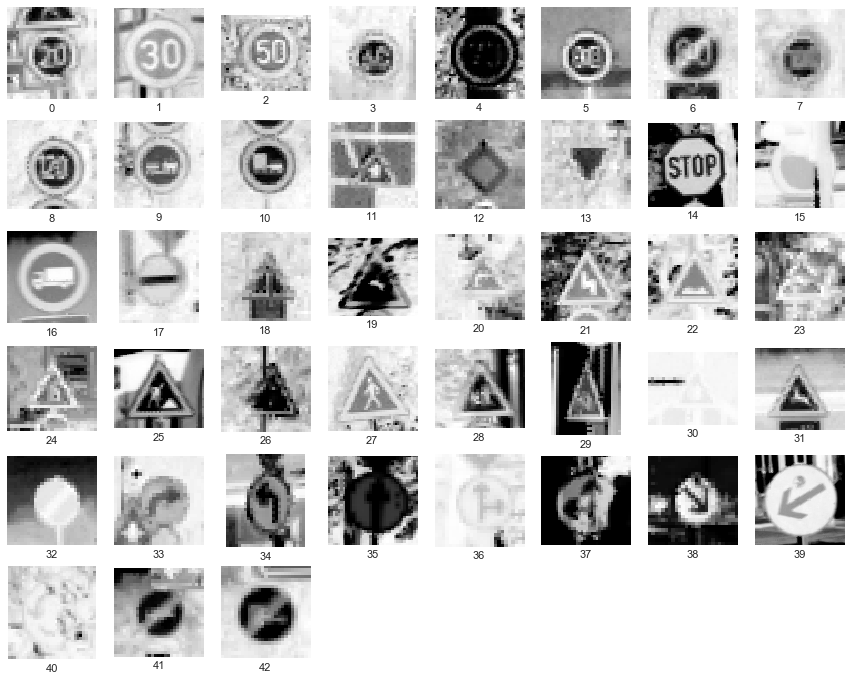

In [4]:
# one image example from each class, pre grayscale and downsizing
plt.figure(figsize = (15, 12))
for i in range(num_classes):
    plt.subplot(6, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(gray_GTSRB[data_class.tolist().index([i])], cmap = plt.cm.binary)
    plt.xlabel(i)
plt.show()

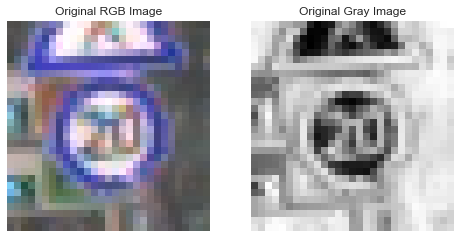

In [5]:
# original and post grayscale comparison 
plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_GTSRB[0], cmap = plt.cm.binary)
plt.title('Original RGB Image')
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(gray_GTSRB[0], cmap = plt.cm.binary)
plt.title('Original Gray Image')
plt.show()

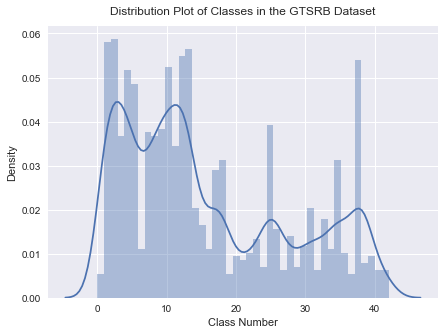

Total 39209 images in the GTSRB dataset
Total 39209 classes in the GTSRB class


In [6]:
# original class distribution
fig = plt.figure(figsize = (7, 5))
sns.distplot(data_class, bins = num_classes)
plt.title('Distribution Plot of Classes in the GTSRB Dataset', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

# length of the data
print('Total %i images in the GTSRB dataset' % len(data_GTSRB))
print('Total %i classes in the GTSRB class' % len(data_class))

### Thresholding + Principal Component Analysis

In [7]:
# Adaptive Mean Thresholding
th_gray_data = np.array([cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, \
                                               cv2.THRESH_BINARY, 11, 2) for img in gray_GTSRB])

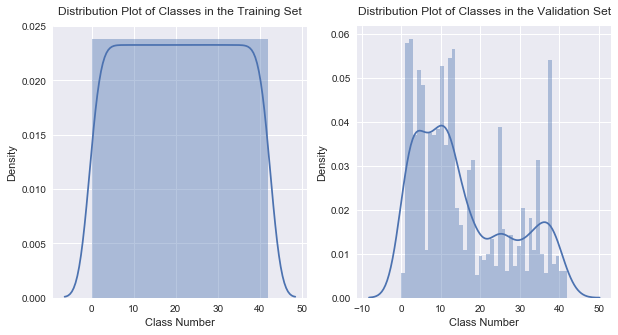

Total of 8514 images in the training data
Total of 2157 images in the validation data
79.79 percent training set, 20.21 percent validation set


In [8]:
# resizing
th_resize_data1 = GTSRB_sungil.resize_all(th_gray_data, size = (16, 16))

# reshaping for classifications
th_reshaped1 = GTSRB_sungil.clf_reshape(th_resize_data1)

# normalizing data, RGB/grayscale images are out of 255
norm_th_reshaped1 = th_reshaped1 / 255.0

# 80% train 20% test split
# test_size was set to 0.055, to maintain the validation set size to 20% post under-sampling
th_train1, th_x_val1, th_class1, th_y_val1 = train_test_split(norm_th_reshaped1, data_class,\
                                                          stratify = data_class, test_size = 0.055)

# random under-sampling
und_th_train1, und_th_class1 = GTSRB_sungil.under_sample(th_train1, th_class1)

# post split class distribution
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.distplot(und_th_class1, bins = num_classes)
plt.title('Distribution Plot of Classes in the Training Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.distplot(th_y_val1, bins = num_classes)
plt.title('Distribution Plot of Classes in the Validation Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(und_th_train1) + len(th_x_val1)
print('Total of %i images in the training data' % len(und_th_train1))
print('Total of %i images in the validation data' % len(th_x_val1))
print('%0.2f percent training set, %0.2f percent validation set' \
      % (len(und_th_train1)/tot_len*100, len(th_x_val1)/tot_len*100))

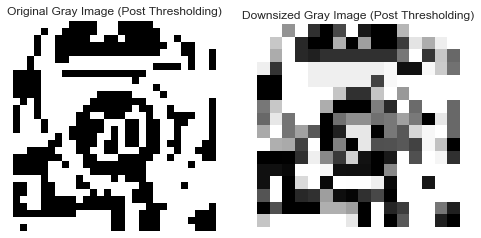

In [9]:
# post thresholding and downsizing comparison 
plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(th_gray_data[0], cmap = plt.cm.binary)
plt.title('Original Gray Image (Post Thresholding)')
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(th_resize_data1[0], cmap = plt.cm.binary)
plt.title('Downsized Gray Image (Post Thresholding)')
plt.show()

In [10]:
# performing PCA on the reshaped thresheld data
th_PCA = PCA(n_components = 0.95).fit(und_th_train1)
th_prin_comps = th_PCA.transform(und_th_train1)
print('In order to capture at least 95% of variance within the original data,', \
      th_PCA.n_components_, 'principal components are needed.')
print('Shape of the original normalized grayscale data:', und_th_train1.shape)
print('Shape of the newly computed principal components:', th_prin_comps.shape)

In order to capture at least 95% of variance within the original data, 208 principal components are needed.
Shape of the original normalized grayscale data: (8514, 256)
Shape of the newly computed principal components: (8514, 208)


In [11]:
# model (w/ default parameters) comparison
Models_sungil.compare_fin_clf(th_prin_comps, und_th_class1, cv = 5)

Comparing Different Classifiers:
-----------------------------------------------------------------
Random Forest Classifier Acc: 0.303 (+/- 0.00)
CV Runtime: 13.024638414382935 
-----------------------------------------------------------------
SVM Classifier Acc: 0.802 (+/- 0.01)
CV Runtime: 282.2442169189453 
-----------------------------------------------------------------
Multi-layer Perceptron Classifier Acc: 0.824 (+/- 0.02)
CV Runtime: 177.68762254714966 
-----------------------------------------------------------------
The classifier (with default parameters) with the highest accuracy is Multi-layer Perceptron Classifier
The cross-validation accuracy is 0.824 (+/- 0.02)


### Thresholding + Wrapper-based Feature Selection (w/ RandomForestClassifier)

Wrapper Select:

Selected: [[182], [210], [234], [235], [236], [237], [238], [239], [241], [243], [262], [263], [264], [265], [266], [267], [268], [269], [270], [271], [289], [290], [291], [292], [293], [294], [295], [296], [297], [298], [299], [316], [317], [318], [319], [320], [321], [322], [323], [324], [325], [326], [327], [328], [344], [345], [346], [347], [348], [349], [350], [351], [352], [353], [354], [355], [371], [372], [373], [374], [375], [376], [377], [378], [379], [380], [381], [382], [383], [384], [385], [400], [401], [402], [403], [404], [405], [406], [407], [408], [409], [410], [411], [412], [414], [428], [429], [430], [431], [432], [433], [434], [435], [436], [437], [438], [439], [440], [441], [455], [456], [457], [458], [459], [460], [461], [462], [463], [464], [465], [466], [467], [468], [484], [485], [486], [487], [488], [489], [490], [491], [492], [493], [494], [495], [496], [512], [513], [514], [515], [516], [517], [518], [519], [520], [521], [522], [523], [524],

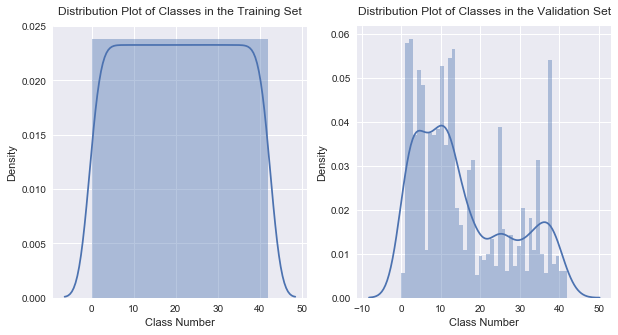

Total of 8514 images in the training data
Total of 2157 images in the validation data
79.79 percent training set, 20.21 percent validation set


In [12]:
# resizing
th_resize_data2 = GTSRB_sungil.resize_all(th_gray_data, size = (28, 28))

# reshaping for classifications
th_reshaped2 = GTSRB_sungil.clf_reshape(th_resize_data2)

# normalizing data, RGB/grayscale images are out of 255
norm_th_reshaped2 = th_reshaped2 / 255.0

# wrapper-based feature selection
th_fs_data = Models_sungil.wrapper_based_fs(norm_th_reshaped2, data_class, clf = RandomForestClassifier())

# 80% train 20% test split
# test_size was set to 0.055, to maintain the validation set size to 20% post under-sampling
th_train2, th_x_val2, th_class2, th_y_val2 = train_test_split(th_fs_data, data_class,\
                                                          stratify = data_class, test_size = 0.055)

# random under-sampling
und_th_train2, und_th_class2 = GTSRB_sungil.under_sample(th_train2, th_class2)

# post split class distribution
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.distplot(und_th_class2, bins = num_classes)
plt.title('Distribution Plot of Classes in the Training Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.distplot(th_y_val2, bins = num_classes)
plt.title('Distribution Plot of Classes in the Validation Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(und_th_train2) + len(th_x_val2)
print('Total of %i images in the training data' % len(und_th_train2))
print('Total of %i images in the validation data' % len(th_x_val2))
print('%0.2f percent training set, %0.2f percent validation set' \
      % (len(und_th_train2)/tot_len*100, len(th_x_val2)/tot_len*100))

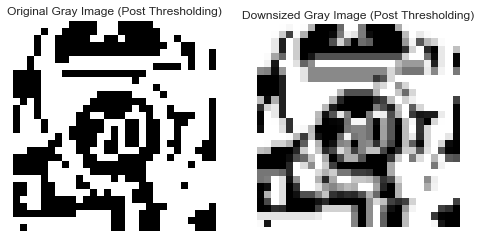

In [13]:
# post thresholding and downsizing comparison 
plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(th_gray_data[0], cmap = plt.cm.binary)
plt.title('Original Gray Image (Post Thresholding)')
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(th_resize_data2[0], cmap = plt.cm.binary)
plt.title('Downsized Gray Image (Post Thresholding)')
plt.show()

In [14]:
# model (w/ default parameters) comparison
Models_sungil.compare_fin_clf(und_th_train2, und_th_class2, cv = 5)

Comparing Different Classifiers:
-----------------------------------------------------------------
Random Forest Classifier Acc: 0.820 (+/- 0.01)
CV Runtime: 7.335403680801392 
-----------------------------------------------------------------
SVM Classifier Acc: 0.903 (+/- 0.01)
CV Runtime: 174.47424483299255 
-----------------------------------------------------------------
Multi-layer Perceptron Classifier Acc: 0.892 (+/- 0.02)
CV Runtime: 250.63368153572083 
-----------------------------------------------------------------
The classifier (with default parameters) with the highest accuracy is SVM Classifier
The cross-validation accuracy is 0.903 (+/- 0.01)


### Canny Edge Detection + Principal Component Analysis

In [15]:
# edge detection
data_edge = GTSRB_sungil.canny_edge_convrt(gray_GTSRB)

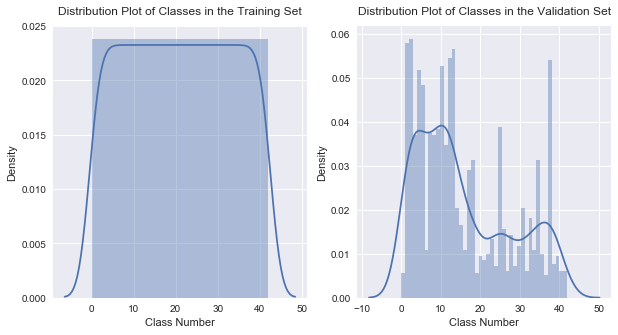

Total of 8514 images in the training data
Total of 2157 images in the validation data
79.79 percent training set, 20.21 percent validation set


In [16]:
# resizing
edge_resize_data1 = GTSRB_sungil.resize_all(data_edge, size = (16, 16))

# reshaping for classifications
edge_reshaped1 = GTSRB_sungil.clf_reshape(edge_resize_data1)

# normalizing data, RGB/grayscale images are out of 255
norm_edge_reshaped1 = edge_reshaped1 / 255.0

# 80% train 20% test split
# test_size was set to 0.055, to maintain the validation set size to 20% post under-sampling
edge_train1, edge_x_val1, edge_class1, edge_y_val1 = train_test_split(norm_edge_reshaped1, data_class,\
                                                                  stratify = data_class, \
                                                                  test_size = 0.055)

# random under-sampling
und_edge_train1, und_edge_class1 = GTSRB_sungil.under_sample(edge_train1, edge_class1)

# post split class distribution
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.distplot(und_edge_class1, bins = num_classes)
plt.title('Distribution Plot of Classes in the Training Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.distplot(edge_y_val1, bins = num_classes)
plt.title('Distribution Plot of Classes in the Validation Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(und_edge_train1) + len(edge_x_val1)
print('Total of %i images in the training data' % len(und_edge_train1))
print('Total of %i images in the validation data' % len(edge_x_val1))
print('%0.2f percent training set, %0.2f percent validation set' \
      % (len(und_edge_train1)/tot_len*100, len(edge_x_val1)/tot_len*100))

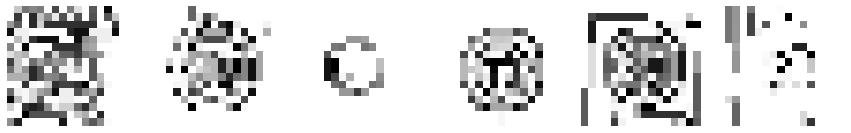

In [17]:
# first 6 edge detected images
img_num_List = [0, 2053, 5254, 7536, 100, 222]
fig = plt.figure(figsize = (15, 6))
for i in range(len(img_num_List)):
    plt.subplot(1, 6, i+1)
    plt.imshow(edge_resize_data1[img_num_List[i]], cmap = plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
plt.show()

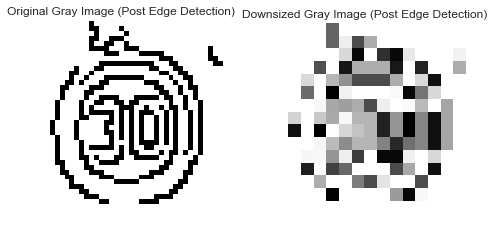

In [18]:
# post edge detection and downsizing comparison 
plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_edge[2053], cmap = plt.cm.binary)
plt.title('Original Gray Image (Post Edge Detection)')
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(edge_resize_data1[2053], cmap = plt.cm.binary)
plt.title('Downsized Gray Image (Post Edge Detection)')
plt.show()

In [19]:
# performing PCA on the reshaped edge detected data
edge_PCA = PCA(n_components = 0.95).fit(und_edge_train1)
edge_prin_comps = edge_PCA.transform(und_edge_train1)
print('In order to capture at least 95% of variance within the original data,', \
      edge_PCA.n_components_, 'principal components are needed.')
print('Shape of the original normalized grayscale data:', und_edge_train1.shape)
print('Shape of the newly computed principal components:', edge_prin_comps.shape)

In order to capture at least 95% of variance within the original data, 216 principal components are needed.
Shape of the original normalized grayscale data: (8514, 256)
Shape of the newly computed principal components: (8514, 216)


In [20]:
# model (w/ default parameters) comparison
Models_sungil.compare_fin_clf(edge_prin_comps, und_edge_class1, cv = 5)

Comparing Different Classifiers:
-----------------------------------------------------------------
Random Forest Classifier Acc: 0.132 (+/- 0.02)
CV Runtime: 19.937016010284424 
-----------------------------------------------------------------
SVM Classifier Acc: 0.389 (+/- 0.01)
CV Runtime: 370.00524163246155 
-----------------------------------------------------------------
Multi-layer Perceptron Classifier Acc: 0.433 (+/- 0.01)
CV Runtime: 277.4555401802063 
-----------------------------------------------------------------
The classifier (with default parameters) with the highest accuracy is Multi-layer Perceptron Classifier
The cross-validation accuracy is 0.433 (+/- 0.01)


### Canny Edge Detection + Wrapper-based Feature Selection (w/ RandomForestClassifier)

Wrapper Select:

Selected: [[82], [113], [130], [131], [132], [133], [137], [138], [152], [153], [154], [155], [157], [158], [159], [160], [162], [175], [176], [177], [178], [179], [180], [181], [182], [183], [184], [185], [198], [199], [200], [201], [202], [203], [204], [205], [206], [207], [208], [209], [210], [221], [222], [223], [224], [225], [226], [227], [228], [229], [230], [231], [232], [233], [234], [235], [246], [247], [248], [249], [250], [251], [252], [253], [254], [255], [256], [257], [258], [259], [270], [271], [272], [273], [274], [275], [276], [277], [278], [279], [280], [281], [282], [283], [294], [295], [296], [297], [298], [299], [300], [301], [302], [303], [304], [305], [306], [318], [319], [320], [321], [322], [323], [324], [325], [326], [327], [328], [329], [330], [331], [342], [343], [344], [345], [346], [347], [348], [349], [350], [351], [352], [353], [354], [355], [366], [367], [368], [369], [370], [371], [372], [373], [374], [375], [376], [377], [378], [379], 

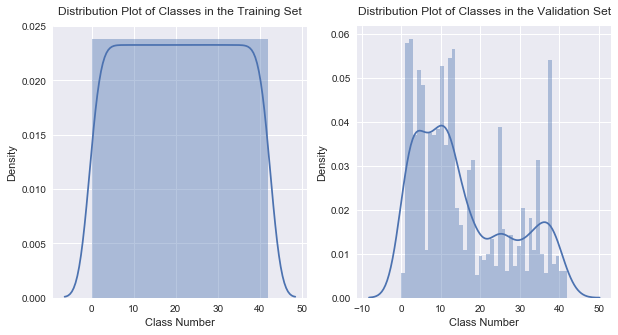

Total of 8514 images in the training data
Total of 2157 images in the validation data
79.79 percent training set, 20.21 percent validation set


In [21]:
# resizing
edge_resize_data2 = GTSRB_sungil.resize_all(data_edge, size = (24, 24))

# reshaping for classifications
edge_reshaped2 = GTSRB_sungil.clf_reshape(edge_resize_data2)

# normalizing data, RGB/grayscale images are out of 255
norm_edge_reshaped2 = edge_reshaped2 / 255.0

# wrapper-based feature selection
edge_fs_data = Models_sungil.wrapper_based_fs(norm_edge_reshaped2, data_class, clf = RandomForestClassifier())

# 80% train 20% test split
# test_size was set to 0.055, to maintain the validation set size to 20% post under-sampling
edge_train2, edge_x_val2, edge_class2, edge_y_val2 = train_test_split(edge_fs_data, data_class,\
                                                                  stratify = data_class, \
                                                                  test_size = 0.055)

# random under-sampling
und_edge_train2, und_edge_class2 = GTSRB_sungil.under_sample(edge_train2, edge_class2)

# post split class distribution
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.distplot(und_edge_class2, bins = num_classes)
plt.title('Distribution Plot of Classes in the Training Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.distplot(edge_y_val2, bins = num_classes)
plt.title('Distribution Plot of Classes in the Validation Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(und_edge_train2) + len(edge_x_val2)
print('Total of %i images in the training data' % len(und_edge_train2))
print('Total of %i images in the validation data' % len(edge_x_val2))
print('%0.2f percent training set, %0.2f percent validation set' \
      % (len(und_edge_train2)/tot_len*100, len(edge_x_val2)/tot_len*100))

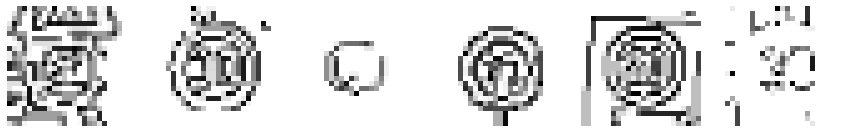

In [22]:
# first 6 edge detected images
img_num_List = [0, 2053, 5254, 7536, 100, 222]
fig = plt.figure(figsize = (15, 6))
for i in range(len(img_num_List)):
    plt.subplot(1, 6, i+1)
    plt.imshow(edge_resize_data2[img_num_List[i]], cmap = plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
plt.show()

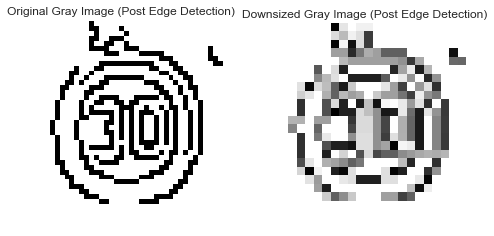

In [23]:
# post edge detection and downsizing comparison 
plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_edge[2053], cmap = plt.cm.binary)
plt.title('Original Gray Image (Post Edge Detection)')
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(edge_resize_data2[2053], cmap = plt.cm.binary)
plt.title('Downsized Gray Image (Post Edge Detection)')
plt.show()

In [24]:
# model (w/ default parameters) comparison
Models_sungil.compare_fin_clf(und_edge_train2, und_edge_class2, cv = 5)

Comparing Different Classifiers:
-----------------------------------------------------------------
Random Forest Classifier Acc: 0.432 (+/- 0.00)
CV Runtime: 4.409778118133545 
-----------------------------------------------------------------
SVM Classifier Acc: 0.490 (+/- 0.01)
CV Runtime: 293.7038152217865 
-----------------------------------------------------------------
Multi-layer Perceptron Classifier Acc: 0.528 (+/- 0.03)
CV Runtime: 250.2512171268463 
-----------------------------------------------------------------
The classifier (with default parameters) with the highest accuracy is Multi-layer Perceptron Classifier
The cross-validation accuracy is 0.528 (+/- 0.03)


### Feature Extraction - Histogram of Oriented Gradients

In [25]:
# HOG features
data_hog = GTSRB_sungil.hog_compute(gray_GTSRB)

HOG feature computation runtime: 13094.809652805328


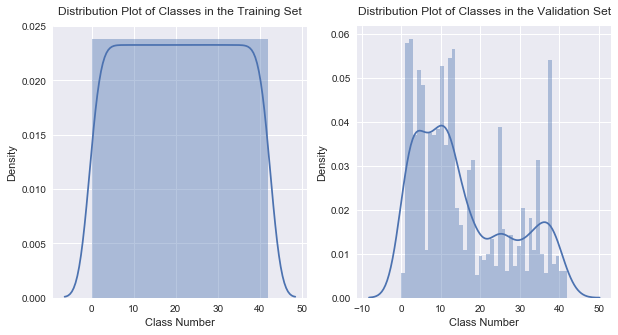

Total of 8514 images in the training data
Total of 2157 images in the validation data
79.79 percent training set, 20.21 percent validation set


In [26]:
# resizing
hog_resize_data = GTSRB_sungil.resize_all(data_hog, size = (16, 16))

# reshaping for classifications
hog_reshaped = GTSRB_sungil.clf_reshape(hog_resize_data)

# normalizing data, RGB/grayscale images are out of 255
norm_hog_reshaped = hog_reshaped / 255.0

# 80% train 20% test split
# test_size was set to 0.055, to maintain the validation set size to 20% post under-sampling
hog_train, hog_x_val, hog_class, hog_y_val = train_test_split(norm_hog_reshaped, data_class,\
                                                          stratify = data_class, test_size = 0.055)

# random under-sampling
und_hog_train, und_hog_class = GTSRB_sungil.under_sample(hog_train, hog_class)

# post split class distribution
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.distplot(und_hog_class, bins = num_classes)
plt.title('Distribution Plot of Classes in the Training Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.distplot(hog_y_val, bins = num_classes)
plt.title('Distribution Plot of Classes in the Validation Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(und_hog_train) + len(hog_x_val)
print('Total of %i images in the training data' % len(und_hog_train))
print('Total of %i images in the validation data' % len(hog_x_val))
print('%0.2f percent training set, %0.2f percent validation set' \
      % (len(und_hog_train)/tot_len*100, len(hog_x_val)/tot_len*100))

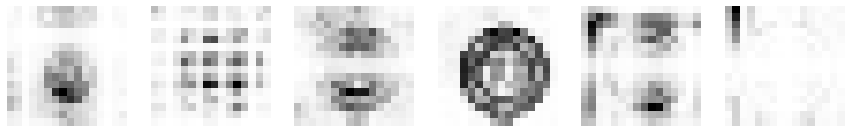

In [29]:
# first 6 HOG images
img_num_List = [0, 2053, 5254, 7536, 100, 222]
fig = plt.figure(figsize = (15, 6))
for i in range(len(img_num_List)):
    plt.subplot(1, 6, i+1)
    plt.imshow(hog_resize_data[img_num_List[i]], cmap = plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
plt.show()

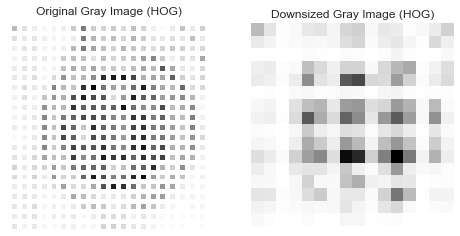

In [48]:
# post edge detection and downsizing comparison 
plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_hog[2053], cmap = plt.cm.binary)
plt.title('Original Gray Image (HOG)')
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(hog_resize_data[2053], cmap = plt.cm.binary)
plt.title('Downsized Gray Image (HOG)')
plt.show()

In [31]:
# model (w/ default parameters) comparison
Models_sungil.compare_fin_clf(und_hog_train, und_hog_class, cv = 5)

Comparing Different Classifiers:
-----------------------------------------------------------------
Random Forest Classifier Acc: 0.225 (+/- 0.01)
CV Runtime: 17.219892501831055 
-----------------------------------------------------------------
SVM Classifier Acc: 0.075 (+/- 0.01)
CV Runtime: 491.51233434677124 
-----------------------------------------------------------------
Multi-layer Perceptron Classifier Acc: 0.446 (+/- 0.03)
CV Runtime: 476.83598160743713 
-----------------------------------------------------------------
The classifier (with default parameters) with the highest accuracy is Multi-layer Perceptron Classifier
The cross-validation accuracy is 0.446 (+/- 0.03)


### HOG features + Principal Component Analysis

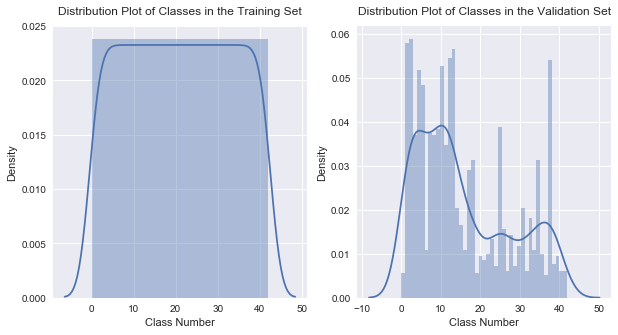

Total of 8514 images in the training data
Total of 2157 images in the validation data
79.79 percent training set, 20.21 percent validation set


In [32]:
# resizing
hog_resize_data1 = GTSRB_sungil.resize_all(data_hog, size = (16, 16))

# reshaping for classifications
hog_reshaped1 = GTSRB_sungil.clf_reshape(hog_resize_data1)

# normalizing data, RGB/grayscale images are out of 255
norm_hog_reshaped1 = hog_reshaped1 / 255.0

# 80% train 20% test split
# test_size was set to 0.055, to maintain the validation set size to 20% post under-sampling
hog_train1, hog_x_val1, hog_class1, hog_y_val1 = train_test_split(norm_hog_reshaped1, data_class,\
                                                                  stratify = data_class, \
                                                                  test_size = 0.055)

# random under-sampling
und_hog_train1, und_hog_class1 = GTSRB_sungil.under_sample(hog_train1, hog_class1)

# post split class distribution
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.distplot(und_hog_class1, bins = num_classes)
plt.title('Distribution Plot of Classes in the Training Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.distplot(hog_y_val1, bins = num_classes)
plt.title('Distribution Plot of Classes in the Validation Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(und_hog_train1) + len(hog_x_val1)
print('Total of %i images in the training data' % len(und_hog_train1))
print('Total of %i images in the validation data' % len(hog_x_val1))
print('%0.2f percent training set, %0.2f percent validation set' \
      % (len(und_hog_train1)/tot_len*100, len(hog_x_val1)/tot_len*100))

In [33]:
# performing PCA on the reshaped hog data
hog_PCA = PCA(n_components = 0.95).fit(und_hog_train1)
hog_prin_comps = hog_PCA.transform(und_hog_train1)
print('In order to capture at least 95% of variance within the original data,', \
      hog_PCA.n_components_, 'principal components are needed.')
print('Shape of the original normalized grayscale data:', und_hog_train1.shape)
print('Shape of the newly computed principal components:', hog_prin_comps.shape)

In order to capture at least 95% of variance within the original data, 190 principal components are needed.
Shape of the original normalized grayscale data: (8514, 256)
Shape of the newly computed principal components: (8514, 190)


In [34]:
# model (w/ default parameters) comparison
Models_sungil.compare_fin_clf(hog_prin_comps, und_hog_class1, cv = 5)

Comparing Different Classifiers:
-----------------------------------------------------------------
Random Forest Classifier Acc: 0.100 (+/- 0.02)
CV Runtime: 16.66072726249695 
-----------------------------------------------------------------
SVM Classifier Acc: 0.079 (+/- 0.01)
CV Runtime: 388.04602217674255 
-----------------------------------------------------------------
Multi-layer Perceptron Classifier Acc: 0.457 (+/- 0.02)
CV Runtime: 408.1115777492523 
-----------------------------------------------------------------
The classifier (with default parameters) with the highest accuracy is Multi-layer Perceptron Classifier
The cross-validation accuracy is 0.457 (+/- 0.02)


### HOG Features + Wrapper-based Feature Selection (w/ RandomForestClassifier)

Wrapper Select:

Selected: [[9], [11], [131], [155], [156], [158], [159], [164], [179], [180], [181], [182], [183], [184], [196], [198], [199], [200], [201], [202], [203], [204], [205], [206], [207], [208], [209], [210], [222], [223], [224], [225], [226], [227], [228], [229], [230], [231], [232], [233], [234], [235], [236], [245], [246], [247], [248], [249], [250], [251], [252], [253], [254], [255], [258], [259], [269], [270], [271], [272], [273], [274], [275], [276], [277], [278], [279], [282], [283], [284], [293], [294], [295], [296], [297], [298], [299], [300], [301], [302], [303], [304], [306], [307], [308], [309], [318], [319], [320], [321], [322], [323], [324], [325], [326], [327], [329], [330], [331], [332], [343], [344], [345], [346], [347], [348], [349], [350], [351], [352], [353], [354], [356], [367], [368], [369], [370], [371], [372], [373], [374], [375], [376], [377], [378], [379], [392], [393], [394], [395], [396], [397], [398], [399], [400], [401], [415], [416], [417], [4

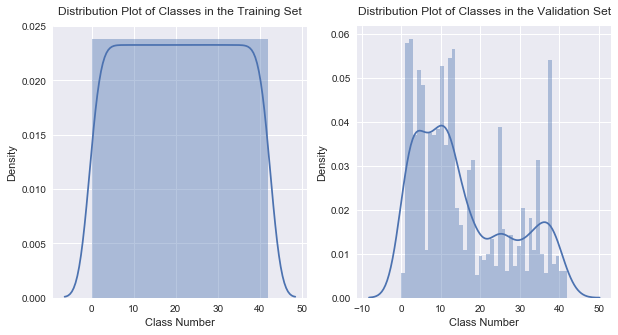

Total of 8514 images in the training data
Total of 2157 images in the validation data
79.79 percent training set, 20.21 percent validation set


In [35]:
# resizing
hog_resize_data2 = GTSRB_sungil.resize_all(data_hog, size = (24, 24))

# reshaping for classifications
hog_reshaped2 = GTSRB_sungil.clf_reshape(hog_resize_data2)

# normalizing data, RGB/grayscale images are out of 255
norm_hog_reshaped2 = hog_reshaped2 / 255.0

# wrapper-based feature selection
hog_fs_data = Models_sungil.wrapper_based_fs(norm_hog_reshaped2, data_class, clf = RandomForestClassifier())

# 80% train 20% test split
# test_size was set to 0.055, to maintain the validation set size to 20% post under-sampling
hog_train2, hog_x_val2, hog_class2, hog_y_val2 = train_test_split(hog_fs_data, data_class,\
                                                                  stratify = data_class, \
                                                                  test_size = 0.055)

# random under-sampling
und_hog_train2, und_hog_class2 = GTSRB_sungil.under_sample(hog_train2, hog_class2)

# post split class distribution
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.distplot(und_hog_class2, bins = num_classes)
plt.title('Distribution Plot of Classes in the Training Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.distplot(hog_y_val2, bins = num_classes)
plt.title('Distribution Plot of Classes in the Validation Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(und_hog_train2) + len(hog_x_val2)
print('Total of %i images in the training data' % len(und_hog_train2))
print('Total of %i images in the validation data' % len(hog_x_val2))
print('%0.2f percent training set, %0.2f percent validation set' \
      % (len(und_hog_train2)/tot_len*100, len(hog_x_val2)/tot_len*100))

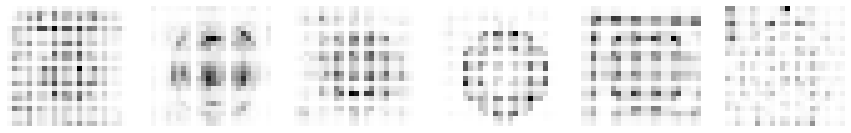

In [36]:
# first 6 HOG images
img_num_List = [0, 2053, 5254, 7536, 100, 222]
fig = plt.figure(figsize = (15, 6))
for i in range(len(img_num_List)):
    plt.subplot(1, 6, i+1)
    plt.imshow(hog_resize_data2[img_num_List[i]], cmap = plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
plt.show()

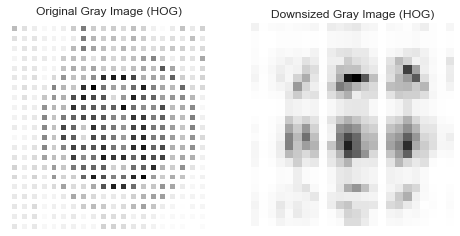

In [49]:
# post HOG and downsizing comparison 
plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_hog[2053], cmap = plt.cm.binary)
plt.title('Original Gray Image (HOG)')
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(hog_resize_data2[2053], cmap = plt.cm.binary)
plt.title('Downsized Gray Image (HOG)')
plt.show()

In [38]:
# model (w/ default parameters) comparison
Models_sungil.compare_fin_clf(und_hog_train2, und_hog_class2, cv = 5)

Comparing Different Classifiers:
-----------------------------------------------------------------
Random Forest Classifier Acc: 0.280 (+/- 0.02)
CV Runtime: 16.97535729408264 
-----------------------------------------------------------------
SVM Classifier Acc: 0.092 (+/- 0.01)
CV Runtime: 336.77190375328064 
-----------------------------------------------------------------
Multi-layer Perceptron Classifier Acc: 0.554 (+/- 0.01)
CV Runtime: 567.7399332523346 
-----------------------------------------------------------------
The classifier (with default parameters) with the highest accuracy is Multi-layer Perceptron Classifier
The cross-validation accuracy is 0.554 (+/- 0.01)


### Hypertuning parameters - Top 2 models

#### Random Forest Classifier w/ Thresholding + Feature Selection (Wrapper-based)

In [41]:
# preparing a parameter grid
param_grid = {"n_estimators": sp_randint(10, 1000), "max_depth": [3, 4, None], "max_features": ['auto', 'log2', None], \
              "min_samples_split": sp_randint(2, 16), "criterion": ["gini", "entropy"]}

# creating and fitting a Random Forest Classifier, testing random param_grids
start_ts = time.time()
model = RandomForestClassifier()
rsearch = RandomizedSearchCV(estimator = model, param_distributions = param_grid, scoring = 'accuracy', cv = 5)
rsearch.fit(und_th_train2, und_th_class2)
print("CV Runtime:", time.time() - start_ts)

# summarizing the results of the random parameter search
print('The best RandomizedSearchCV score:', rsearch.best_score_)
print('The best estimator:\n', rsearch.best_estimator_)

trainacc_List = ['0.905826', '0.924114', '0.866544']
trainacc_List.append(rsearch.best_score_)

CV Runtime: 5605.90757226944
The best RandomizedSearchCV score: 0.9341085271317829
The best estimator:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=751, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


Random Forest Classifier (w/ hypertuned parameters) Testing Acc: 0.919
CV Runtime: 57.20699954032898
Random Forest classification report: 

               precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.92      0.83      0.87       122
           2       0.95      0.78      0.86       124
           3       0.86      0.92      0.89        78
           4       0.86      0.95      0.90       109
           5       0.83      0.72      0.77       102
           6       1.00      0.96      0.98        23
           7       0.94      0.86      0.90        79
           8       0.91      0.88      0.90        78
           9       0.93      1.00      0.96        81
          10       0.95      0.95      0.95       111
          11       1.00      0.89      0.94        73
          12       0.97      0.86      0.91       115
          13       0.98      0.99      0.98       119
          14       0.90      1.00      0.95     

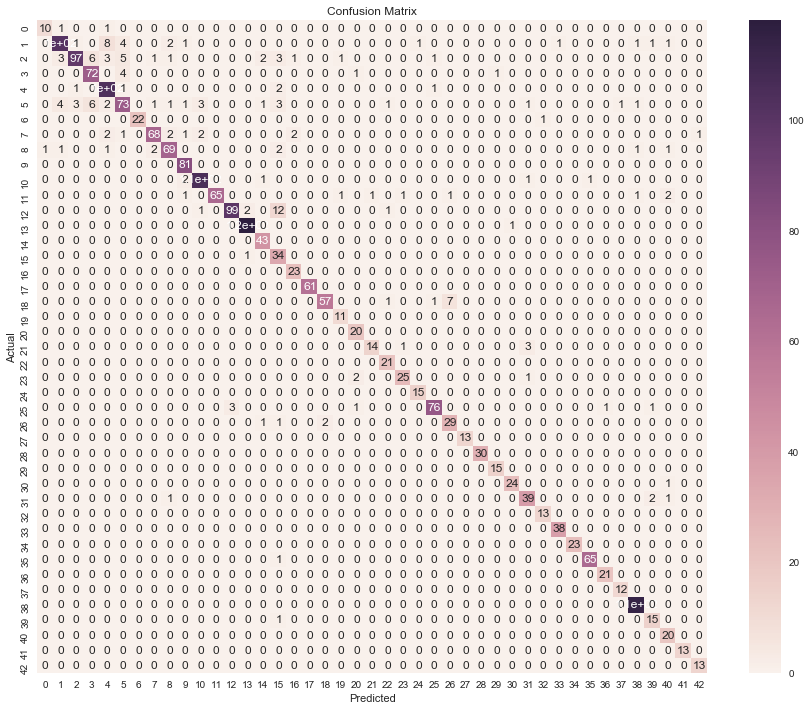

In [42]:
# testing on the unbalanced validation set
start_ts = time.time()
rsearch.best_estimator_.fit(und_th_train2, und_th_class2)
test_acc = rsearch.best_estimator_.score(th_x_val2, th_y_val2)
print('Random Forest Classifier (w/ hypertuned parameters) Testing Acc: %0.3f'% (test_acc))
print("CV Runtime:", time.time() - start_ts)

# classification report
pred = rsearch.best_estimator_.predict(th_x_val2)
print("Random Forest classification report:", "\n\n", classification_report(th_y_val2, pred))
precision, recall, fbeta_score, support = precision_recall_fscore_support(th_y_val2, pred, average = 'weighted')

clf_List = ['Feature Selected (Wrapper-based) Random Forest Classifier from Part I',\
            'Feature Selected (Wrapper-based) Multi-layer Perceptron Classifier from Part I',\
            'Multi-layer Perceptron Classifier w/ Principal Components from Part I']
testacc_List = ['0.878999', '0.910524', '0.823829']
precision_List = ['0.887589', '0.916128', '0.833671']
recall_List = ['0.878999', '0.910524', '0.823829']
fscore_List = ['0.879842', '0.911308', '0.825159']
clf_List.append('Thresheld + Feature Selected (Wrapper-based) Random Forest Classifier')
testacc_List.append(test_acc)
precision_List.append(precision)
recall_List.append(recall)
fscore_List.append(fbeta_score)

# accuracy confusion matrix
cm = confusion_matrix(th_y_val2, pred)
plt.figure(figsize = (15, 12))
sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.grid(False)
plt.show()

#### Support Vector Machine w/ Thresholding + Feature Selection (Wrapper-based)

In [45]:
# preparing a parameter grid
param_grid = {"C": sp_uniform(0.0001, 10), "kernel": ['linear', 'poly', 'rbf', 'sigmoid'], "gamma": sp_uniform(0.0001, 1)}

# creating and fitting a SVM Classifier, testing random param_grids
start_ts = time.time()
model = SVC()
rsearch = RandomizedSearchCV(estimator = model, param_distributions = param_grid, scoring = 'accuracy', cv = 5)
rsearch.fit(und_th_train2, und_th_class2)
print("CV Runtime:", time.time() - start_ts)

# summarizing the results of the random parameter search
print('The best RandomizedSearchCV score:', rsearch.best_score_)
print('The best estimator:\n', rsearch.best_estimator_)

trainacc_List.append(rsearch.best_score_)

CV Runtime: 2250.0916707515717
The best RandomizedSearchCV score: 0.9411557434813249
The best estimator:
 SVC(C=1.6855093273957915, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.9881919311341273,
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


SVM Classifier (w/ hypertuned parameters) Testing Acc: 0.920
CV Runtime: 15.770519495010376
SVM classification report: 

               precision    recall  f1-score   support

           0       0.75      1.00      0.86        12
           1       0.88      0.89      0.88       122
           2       0.88      0.79      0.83       124
           3       0.79      0.88      0.84        78
           4       0.93      0.91      0.92       109
           5       0.76      0.76      0.76       102
           6       1.00      1.00      1.00        23
           7       0.91      0.86      0.88        79
           8       0.90      0.83      0.87        78
           9       0.99      0.98      0.98        81
          10       0.95      0.95      0.95       111
          11       0.99      0.95      0.97        73
          12       0.89      0.89      0.89       115
          13       0.99      0.99      0.99       119
          14       0.98      0.98      0.98        43
          15 

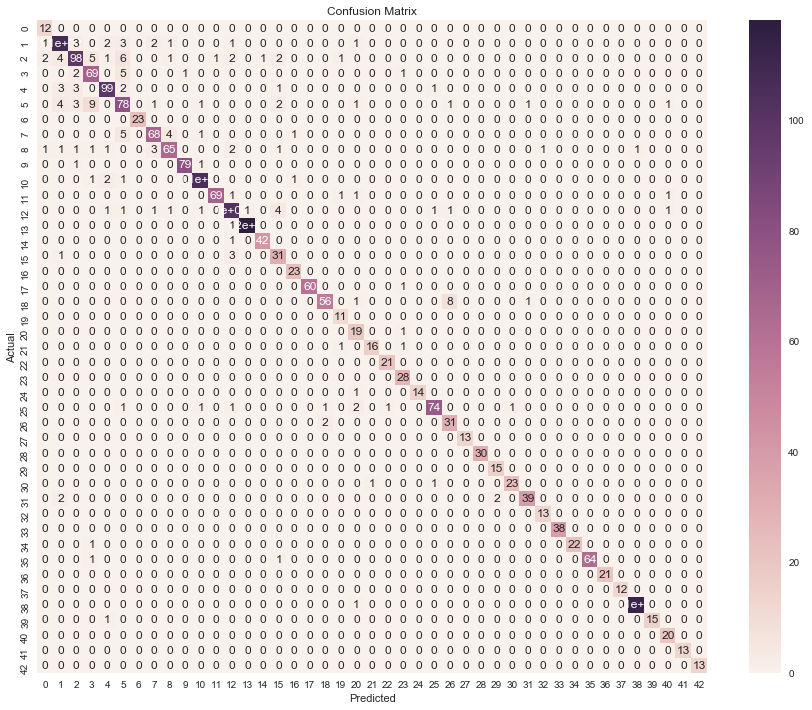

In [46]:
# testing on the unbalanced validation set
start_ts = time.time()
rsearch.best_estimator_.fit(und_th_train2, und_th_class2)
test_acc = rsearch.best_estimator_.score(th_x_val2, th_y_val2)
print('SVM Classifier (w/ hypertuned parameters) Testing Acc: %0.3f'% (test_acc))
print("CV Runtime:", time.time() - start_ts)

# classification report
pred = rsearch.best_estimator_.predict(th_x_val2)
print("SVM classification report:", "\n\n", classification_report(th_y_val2, pred))
precision, recall, fbeta_score, support = precision_recall_fscore_support(th_y_val2, pred, average = 'weighted')

clf_List.append('Thresheld + Feature Selected (Wrapper-based) Support Vector Machine Classifier')
testacc_List.append(test_acc)
precision_List.append(precision)
recall_List.append(recall)
fscore_List.append(fbeta_score)

# accuracy confusion matrix
cm = confusion_matrix(th_y_val2, pred)
plt.figure(figsize = (15, 12))
sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.grid(False)
plt.show()

### Final Results

In [47]:
# final results table
final_results = pd.DataFrame({'Classifiers': clf_List, 'Training (cv = 5) Accuracy': trainacc_List,\
                              'Testing Accuracy': testacc_List, 'Precision Score': precision_List,\
                              'Recall Score': recall_List, 'F-Score': fscore_List}).set_index('Classifiers')
final_results

,Training (cv = 5) Accuracy,Testing Accuracy,Precision Score,Recall Score,F-Score
Classifiers,,,,,
Feature Selected (Wrapper-based) Random Forest Classifier from Part I,0.905826,0.878999,0.887589,0.878999,0.879842
Feature Selected (Wrapper-based) Multi-layer Perceptron Classifier from Part I,0.924114,0.910524,0.916128,0.910524,0.911308
Multi-layer Perceptron Classifier w/ Principal Components from Part I,0.866544,0.823829,0.833671,0.823829,0.825159
Thresheld + Feature Selected (Wrapper-based) Random Forest Classifier,0.934109,0.918869,0.924908,0.918869,0.918973
Thresheld + Feature Selected (Wrapper-based) Support Vector Machine Classifier,0.941156,0.919796,0.923204,0.919796,0.920249


### Final 3 Models

| Classifiers | Precision | Recall | F-Score |
| --- | --- | --- | --- |
| Feature Selected (Wrapper-based) Multi-layer Perceptron Classifier from Part I | 0.916128 | 0.910524 | 0.911308 |
| Thresheld + Feature Selected (Wrapper-based) Random Forest Classifier | 0.924908 | 0.918869 | 0.918973 |
| Thresheld + Feature Selected (Wrapper-based) Support Vector Machine Classifier | 0.923204 | 0.919796 | 0.920249 |
